In [ ]:
#!pip install control
#!pip install slycot
#!pip install plotly
#!pip install nbformat
#!pip install SciencePlots
#!pip install latex


In [1]:
# importa os modulo necessários 

import numpy as np
import matplotlib.pyplot as plt
import sympy as sym
from scipy.integrate import odeint
from matplotlib import animation
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import PillowWriter

import control as ct
from slycot import *
import scienceplots
import latex



# 1 Modelagem pelo módulo Sympy

In [2]:
# Definindo as variáveis simbólicas

# Constantes
M, m1, m2, m3, l1, l2,J1, J2, g, t, f0, f1, f2 = sym.symbols('M m1 m2 m3 l1 l2 J1 J2 g t  f0 f1 f2')

# Variáveis
phi1, phi2, x,u ,theta1, theta2 = sym.symbols(r'phi1 phi2 x u theta1 theta2', cls=sym.Function) # funções para se trabalhar em cima


In [3]:
# Definindo as derivadas no tempo 

x = x(t)  # Posição x do carro 
u = u(t)  # Variável de controle
phi1 = phi1(t) # Ângulo do pêndulo inferior
phi2 = phi2(t) # Ângulo do pêndulo superior
theta1 = theta1(t) # Ângulo do linearizado 
theta2 = theta2(t) # Ângulo do linearizado

x_d = sym.diff(x, t) # Velocidade do carro
phi1_d = sym.diff(phi1, t) # Velocidade angular do pendulo inferior
phi2_d = sym.diff(phi2, t) # Velocidade angular do pendulo superior

x_dd = sym.diff(x_d, t) # Aceleração do carro
phi1_dd = sym.diff(phi1_d, t) # Aceleração angular do pendulo inferior
phi2_dd = sym.diff(phi2_d, t) # Aceleração angular do pendulo superior

# Simplificação
dpdp2=phi2_d*phi2_d
dpdp1=phi1_d*phi1_d
dxdx=x_d*x_d

In [4]:
# Equação de Lagrange: L = T-U

# Energia cinética e potencial carro:
Kc = 1/2 * M *dxdx
Pc = 0

# Energia cinética e potencial do pendulo inferior:
Kp_1 = 1/2 * m1  *dxdx + m1* x_d*l1*phi1_d*sym.cos(phi1)+ 1/2 *dpdp1*(m1*l1*l1+J1)
Pp_1 = m1*g*l1*sym.cos(phi1)

# Energia cinética e potencial do pendulo superior:
Kp_2 = 1/2 *m2*(dxdx + 2*x_d*(2*l1*phi1_d*sym.cos(phi1)+l2*phi2_d*sym.cos(phi2)))\
+1/2 *m2*(4*l1*l1*dpdp1+l2*l2*dpdp2+4*l1*l2*phi1_d*phi2_d*sym.cos(phi1-phi2))+1/2 *J2*dpdp2
Pp_2 = m2*g*(2*l1*sym.cos(phi1)+l2*sym.cos(phi2))

# Energia cinética e potencial total:
P_total = Pc + Pp_1 + Pp_2
K_total = Kc + Kp_1 + Kp_2 
L = K_total - P_total
L

0.5*J2*Derivative(phi2(t), t)**2 + 0.5*M*Derivative(x(t), t)**2 - g*l1*m1*cos(phi1(t)) - g*m2*(2*l1*cos(phi1(t)) + l2*cos(phi2(t))) + l1*m1*cos(phi1(t))*Derivative(phi1(t), t)*Derivative(x(t), t) + 0.5*m1*Derivative(x(t), t)**2 + 0.5*m2*(2*(2*l1*cos(phi1(t))*Derivative(phi1(t), t) + l2*cos(phi2(t))*Derivative(phi2(t), t))*Derivative(x(t), t) + Derivative(x(t), t)**2) + 0.5*m2*(4*l1**2*Derivative(phi1(t), t)**2 + 4*l1*l2*cos(phi1(t) - phi2(t))*Derivative(phi1(t), t)*Derivative(phi2(t), t) + l2**2*Derivative(phi2(t), t)**2) + 0.5*(J1 + l1**2*m1)*Derivative(phi1(t), t)**2

In [5]:
# Equaçoes das variaveis generalizadas:

# Coordenada generalizada X:
eqnx = sym.diff(sym.diff(L,x_d),t)-sym.diff(L,x)-u+f0*x_d

# Coordenada generalizada phi1:
eqn_phi1 = sym.diff(sym.diff(L,phi1_d),t)-sym.diff(L,phi1)+(f1+f2)*phi1_d -f2*phi2_d

# Coordenada generalizada phi2:
eqn_phi2 = sym.diff(sym.diff(L,phi2_d),t)-sym.diff(L,phi2)-f2*phi1_d + f2*phi2_d


# Solução das equaçoes das variáveis generalizadas
# Solução para X
sol_xdd = sym.solve(eqnx, x_dd)[0]
#sol_xdd = sym.solve([eqnx], (x_dd), simplify=False, rational=False)#[0]

# Solução para phi1
sol_phi1dd = sym.solve(eqn_phi1, phi1_dd)[0]
#sol_phi1dd = sym.solve([eqn_phi1], (phi1_dd), simplify=False, rational=False)#[0]

# Solução para phi1
sol_phi2dd = sym.solve(eqn_phi2, phi2_dd)[0]
#sol_phi2dd = sym.solve([eqn_phi2], (phi2_dd), simplify=False, rational=False)#[0]

In [6]:
# Soluciona o sistema de equações das variaveis generalizadas
sols = sym.solve([eqnx, eqn_phi1,eqn_phi2], (x_dd,phi1_dd,phi2_dd),
                simplify=False, rational=False)

### Dinâmica Não Linear

Definindo as equações

$$
\begin{align}
\frac{\mathrm{d} ^2 x}{\mathrm{d} t^2} = \frac{\mathrm{d} \omega  }{\mathrm{d} t} \\
\frac{\mathrm{d} x }{\mathrm{d} t} = \omega
\end{align}
$$
Para $X$

$$
\begin{align}
\frac{\mathrm{d} ^2 \phi}{\mathrm{d} t^2} = \frac{\mathrm{d} \zeta }{\mathrm{d} t} \\
\frac{\mathrm{d} \phi }{\mathrm{d} t} = \zeta
\end{align}
$$
Para cada $\phi\in (\phi_1, \phi_2)$

In [7]:
do1dt_f = sym.lambdify((t, M, m1, m2, g , J1, J2, l1, l2, f0, f1, f2, u, x, phi1, phi2, x_d, phi1_d, phi2_d), sols[x_dd])
dxdt_f = sym.lambdify(x_d, x_d)

dz1dt_f = sym.lambdify((t, M, m1, m2, g , J1, J2, l1, l2, f0, f1, f2, u, x, phi1, phi2, x_d, phi1_d, phi2_d), sols[phi1_dd])
dphi1dt_f = sym.lambdify(phi1_d, phi1_d)

dz2dt_f = sym.lambdify((t, M, m1, m2, g, J1, J2, l1, l2, f0, f1, f2, u, x, phi1, phi2, x_d, phi1_d, phi2_d), sols[phi2_dd])
dphi2dt_f = sym.lambdify(phi2_d, phi2_d)

Define o sistema de ODE para o python $S = (X,\omega,\phi_1,\zeta_1,\phi_2,\zeta_2)$

In [8]:
def dSdt(S, t):
    x, o1, phi1, z1, phi2, z2 = S
    return [
        dxdt_f(o1),
        do1dt_f(t, M, m1, m2, g, J1, J2, l1, l2, f0, f1, f2, u, x, phi1, phi2, o1, z1, z2),
        
        dphi1dt_f(z1),
        dz1dt_f(t, M, m1, m2, g, J1, J2, l1, l2, f0, f1, f2, u, x, phi1, phi2, o1, z1, z2),
        
        dphi2dt_f(z2),
        dz2dt_f(t, M, m1, m2, g, J1, J2, l1, l2, f0, f1, f2, u, x, phi1, phi2, o1, z1, z2),
    ]

In [19]:
# t = np.linspace(0, 20, 2000)
t = np.arange(0,20,0.01)
M=1
m1=1
m2=1
u=0
J1=0.00083
J2=0.00083
l1=0.05
l2=0.05
g=9.81
f0=0.01
f1=0.007
f2=0.007
soluODE = odeint(dSdt, y0=[0, 0.0, 0.08, 0, 0,0], t=t)

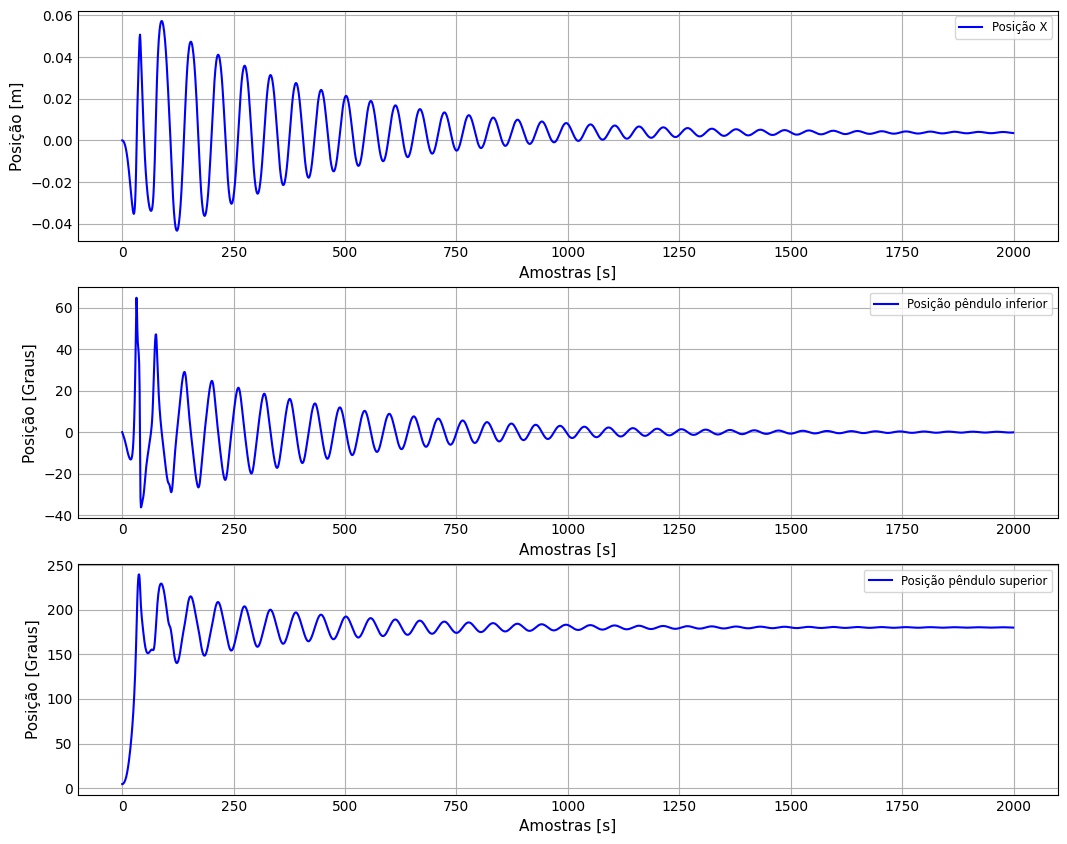

In [25]:
plt.style.use('_mpl-gallery')
plt.figure(figsize=(10,8))
plt.subplot(3,1,1)
plt.plot(soluODE.T[0],'b',linewidth=1.5,label='Posição X')
plt.xlabel('Amostras [s]',fontsize=11)
plt.ylabel('Posição [m]',fontsize=11)
plt.grid(True)
plt.legend(loc='upper right',fontsize='small')

plt.subplot(3,1,2)
plt.plot(soluODE.T[1]*180/np.pi,'b',linewidth=1.5,label='Posição pêndulo inferior')
plt.xlabel('Amostras [s]',fontsize=11)
plt.ylabel('Posição [Graus]',fontsize=11)
plt.grid(True)
plt.legend(loc='upper right',fontsize='small')

plt.subplot(3,1,3)
plt.plot(soluODE.T[2]*180/np.pi,'b',linewidth=1.5,label='Posição pêndulo superior')
plt.xlabel('Amostras [s]',fontsize=11)
plt.ylabel('Posição [Graus]',fontsize=11)
plt.grid(True)
plt.legend(loc='upper right',fontsize='small')

plt.show()

$$
\begin{align}
q_p = \begin{bmatrix}
x\\ \phi_1
\\ \phi_2
\end{bmatrix},\;\;\;\;\;\dot{q}_p = \begin{bmatrix}
\dot{x}\\ \dot{\phi}_1
\\ \dot{\phi}_2
\end{bmatrix},\;\;\;\;\; u_p = \begin{bmatrix}
u\\ 0
\\ 0
\end{bmatrix}
\end{align}
$$

In [ ]:
# Matriz dos estados
q = sym.Matrix([x,theta1,theta2])

# Matriz das derivadas de estados
q_d = sym.Matrix([(x_d,phi1_d,phi2_d)])

# Matriz das 2º derivadas de estados
q_dd = sym.Matrix([(x_dd,phi1_dd,phi2_dd)])

# Matriz estados total
q_ef = sym.Matrix([q,q_dd.transpose()])


# Ponto de equilibrio - Linearização
ponto_eq = {x:0,x_d:0,x_dd:0,phi1:0,phi2:0,phi1_d:0,phi2_d:0,phi2_dd:0,phi1_dd:0,sym.cos(phi1):1,\
            sym.cos(phi2):1,sym.cos(phi1-phi2):1,sym.sin(phi1):theta1,sym.sin(phi2):theta2}


$$
\begin{align}
H(q_p)\ddot{q_p} + N(q_p,\dot{q_p}) + W(q_p) = V(q_p)u_p
\end{align}
$$


Dinâmica Linear

In [ ]:
# Matriz H de Massas do sistema:
H = sym.Matrix((sym.diff(eqnx,q_dd),sym.diff(eqn_phi1,q_dd),sym.diff(eqn_phi2,q_dd))).subs(ponto_eq)

# Matriz H inversa
H_inv = H.inv()
H

In [ ]:
# Matriz de efeito corolis e atritos viscosos
N = sym.Matrix((sym.diff(eqnx,q_d),sym.diff(eqn_phi1,q_d),sym.diff(eqn_phi2,q_d))).subs(ponto_eq)
N

In [ ]:
# Matriz dos efeitos das massas e da gravidade
W = sym.Matrix([0,-g*l1*sym.sin(phi1)*(m1+2*m2),-g*m2*l2*sym.sin(phi2)]).subs(ponto_eq)
W

In [ ]:
# Matriz de entradas
V = sym.Matrix([u,0,0])
V

In [ ]:
# Multiplicação matricial

C = N*q_d.transpose() + W # C+W

S = (H_inv*C).subs(ponto_eq)
S

In [ ]:
B_0 = sym.Matrix([q_dd.transpose(),H_inv*V])
B_0

In [ ]:
# Solução Final 
f = sym.Matrix([q_dd.transpose(),S])
f

In [ ]:
f_s = f.jacobian(q_ef)
f_s

In [ ]:
# Obtendo as matrizes numericas de estados A 

# Valor dos parâmetros do sistema:
valor_param_dGisele = {M:1,m1:1,m2:1,J1:0.00083,J2:0.00083,\
               l1:0.05,l2:0.05,g:9.81,f0:0.01,f1:0.007,f2:0.007}

# Matriz A
A_s = f_s.subs(valor_param_dGisele)
A = np.matrix(A_s).astype(np.float64)
A

In [ ]:
# Matriz B
b_i = B_0.jacobian([u])
B_s = b_i.subs(valor_param_dGisele)
B = np.matrix(B_s).astype(np.float64)
#b_i
B

In [ ]:
# Matriz C
C = np.array([[1, 0, 0, 0, 0, 0],
              [0, 1, 0, 0, 0, 0],
              [0, 0, 1, 0, 0, 0]])

# Matriz D
D = np.zeros((3,1))

In [ ]:
# Criando o sistema em State Space
sys = ct.ss(A,B,C,D)


# Discretização
Ts = 0.01
sys_discreto = ct.c2d(sys,Ts, method='zoh')

Ad = sys_discreto.A
Bd = sys_discreto.B
Cd = sys_discreto.C
print('Sistema Discreto:', sys_discreto)

# 2 Modelagem pelo módulo Numpy

# 3 Estabilidade

In [ ]:
#Exibir Matriz discreta A
sym.Matrix(sys_discreto.A)


In [ ]:
#Exibir Matriz discreta B

sym.Matrix(sys_discreto.B)

In [ ]:
#Exibir Matriz discreta C

sym.Matrix(sys_discreto.C)

In [ ]:
# MAtriz de controlabilidade
Co = ct.ctrb(Ad,Bd)
rank = np.linalg.matrix_rank(Co)    
print('Rank da Matriz de controlabilidade:',rank)
Co_s =sym.Matrix(Co)
Co_s

In [ ]:
# MAtriz de observabilidade
Ob = ct.obsv(Ad,Cd)
rank_obsr = np.linalg.matrix_rank(Ob)    
print('Rank da Matriz de observabilidade:',rank_obsr)
Ob_s = sym.Matrix(Ob)
Ob_s

In [ ]:
# Polos do sistema
polos = ct.poles(sys_discreto)
zeros_s = ct.zeros(sys_discreto)
print('Os polos do sistema são: ', polos \
    , 'Os zeros do sistema são: ',zeros_s)

In [ ]:
# Pólos do sistema

plt.figure(figsize=(6, 6)) 
ct.pzmap(sys_discreto,plot=True,title ='Pólos do sistema',grid=True,marker_color='r',marker_size=6.4,xlim=[0.5,1.2],ylim=[-0.3,0.3],scaling=True)


In [ ]:
# Plotar resposta inicial do sistema

x0 = np.array([[0.0],[0.0],[0.1],[0],[0],[0]])
tp = np.arange(0, 3, Ts) 
#t,y = ct.initial_response(sys, tp,x0) # Resposta Inicial
t,y = ct.initial_response(sys_discreto, tp,x0) # Resposta Inicial
r,d = ct.step_response(sys,tp,x0) # Resposta ao degrau

In [ ]:
plt.style.available

In [ ]:

altura = 4
largura = 9

plt.style.use(['science','no-latex'])
#plt.style.use(['science','seaborn-v0_8-whitegrid'])
subplots = plt.subplots(1, 1, figsize=(largura, altura))
subplots[1].plot(t,y[0], '-r',label='Posio do carro [m]')
subplots[1].plot(t,y[1], '-g',label='Angulo do pendulo inferior [rad]')
subplots[1].plot(t,y[2], label='Angulo do pendulo superior [rad]')
subplots[1].set_title('Resposta Inicial')
subplots[1].set_xlabel('Tempo (s)')
subplots[1].set_ylabel('Posicao (m)')
subplots[1].grid(True)
subplots[1].legend()
plt.show()



In [ ]:
altura = 4
largura = 9
subplots = plt.subplots(1, 1, figsize=(largura, altura))
#subplots[1].plot(t,d[0][0], label='x')
subplots[1].plot(t,d[1][0], label='ângulo phi1')
subplots[1].plot(t,d[2][0], label='ângulo phi2')
subplots[1].set_title('Resposta ao Degrau')
subplots[1].set_xlabel('Tempo (s)')
subplots[1].set_ylabel('Posicao (m)')
subplots[1].grid(True)
subplots[1].legend()
plt.show()